In [2]:
%matplotlib inline

import random
import pickle
import chromadb
import numpy as np
from pprint import pprint
from tqdm.auto import tqdm
import sys
from matplotlib import pyplot as plt
import random

sys.path.append("../")
from utils.parse_arxiv import *
from make_vectordb import get_embedding_model

[nltk_data] Downloading package punkt to /home/zyang37/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# create a random adjacency matrix (graph), user can also specify their numbers of random edges
def create_random_adjacency_matrix(n, num_edges=None):
    adj = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            if random.random() < 0.5:
                adj[i, j] = 1
                adj[j, i] = 1
    if num_edges is not None:
        edges = np.argwhere(adj == 1)
        if len(edges) > num_edges:
            edges = random.sample(list(edges), num_edges)
            adj = np.zeros((n, n))
            for i, j in edges:
                adj[i, j] = 1
                adj[j, i] = 1
    return adj

# a func take in an adjacency matrix and return eigenvalues and eigenvectors
def get_eigen(adj):
    eigenvalues, eigenvectors = np.linalg.eig(adj)
    return eigenvalues, eigenvectors

[0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0, 20]
[ 1.61803399e+00 -1.61803399e+00  6.18033989e-01 -6.18033989e-01
 -1.00000000e+00  1.00000000e+00  1.73205081e+00 -1.73205081e+00
  1.41421356e+00  6.68208043e-17  2.68875246e-17 -1.41421356e+00
  1.90211303e+00  1.17557050e+00 -1.90211303e+00 -1.17557050e+00
  1.00000000e+00 -1.00000000e+00  1.41421356e+00 -1.41421356e+00
  4.14744980e-17  1.00000000e+00  1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.39860165e-16 -1.00000000e+00 -6.22398993e-17
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00

/data/zyang/miniconda3/envs/pt/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/data/zyang/miniconda3/envs/pt/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


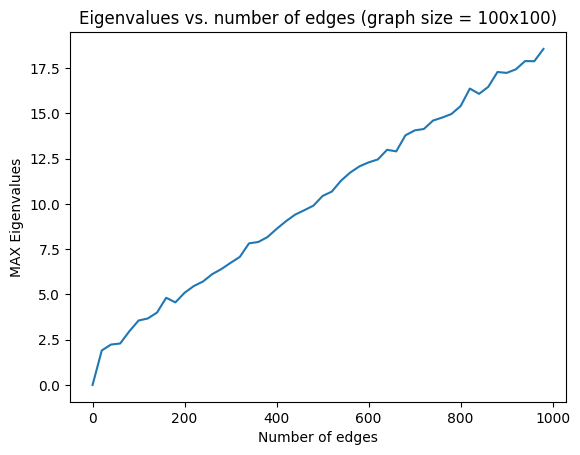

In [4]:
g = create_random_adjacency_matrix(10, 10)
# print(g)
# print()
eigenvalues, eigenvectors = get_eigen(g)
# print(eigenvalues.sum())
# print(eigenvectors)

# make a plot of eigenvalues vs. number of edges (0 to 100, step 10)
n = 100
num_edges = []
eigenvalues_sum = []
for ne in range(0, 1000, 20):
    num_edges.append(ne)
    print(num_edges)
    g = create_random_adjacency_matrix(n, ne)
    eigenvalues, eigenvectors = get_eigen(g)
    eigenvalues_sum.append(eigenvalues.max())
    print(eigenvalues)

plt.plot(num_edges, eigenvalues_sum)
plt.xlabel('Number of edges')
plt.ylabel('MAX Eigenvalues')
plt.title('Eigenvalues vs. number of edges (graph size = {}x{})'.format(n,n))
plt.show()

In [31]:
 # load pickle
g_data = pickle.load(open('../data/arxiv/graph.pickle', 'rb'))
g_data.data_dict['id_1009.5145']

{'author:RaymondH.Y.Louie',
 'author:YonghuiLi',
 'author:andBrankaVucetic',
 'category:cs.IT',
 'category:math.IT',
 'journal:IEEE Transactions on Vehicular Technology, 2010',
 'year:2016'}

In [32]:
# G.keyword_dict.keys()

# a func take in a list and return all combinations of 2 elements, do not use list comprehension
def get_pair_combinations(l):
    result = []
    for i in range(len(l)):
        for j in range(i+1, len(l)):
            result.append((l[i], l[j]))
    return result

In [182]:
# sample networkx graph class
import random
import networkx as nx
import matplotlib.pyplot as plt

class MetadataGraph:
    def __init__(self):
        self.G = nx.Graph()
        self.metadata_nodes = []

    def update_one(self, metadata_set):
        self.add_data_nodes(metadata_set)
        self.connect_edges(metadata_set)

    def add_data_nodes(self, metadata_set):
        metadata_list = list(metadata_set)
        # color hex code random generator
        random_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        self.G.add_nodes_from(metadata_list, color=random_color)
        self.metadata_nodes.extend(metadata_list)

    def connect_edges(self, metadata_set):
        metadata_list = list(metadata_set)
        edge_list = get_pair_combinations(metadata_list)
        self.G.add_edges_from(edge_list)

    def get_adjacency_matrix(self):
        return nx.to_numpy_matrix(self.G)
    
    def get_laplacian_matrix(self):
        return nx.laplacian_matrix(self.G)
    
    def draw(self, with_labels=False, node_size=15):
        colors = [self.G.nodes[n]['color'] for n in self.G.nodes]
        nx.draw(self.G, with_labels=with_labels, node_color=colors, node_size=node_size, pos=nx.spring_layout(self.G), alpha=0.85)

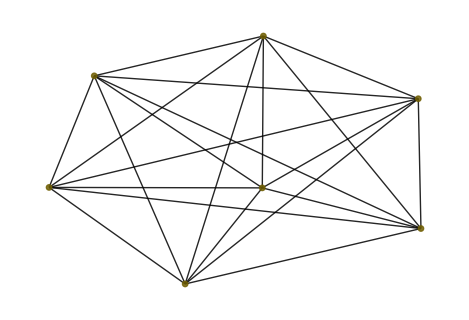

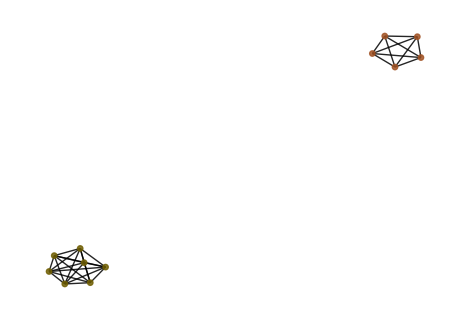

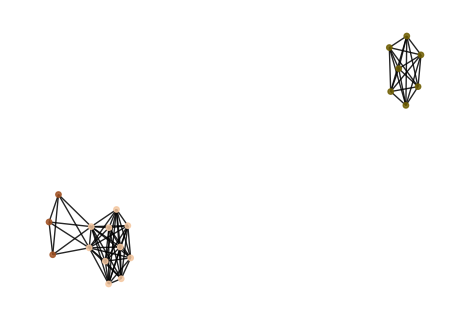

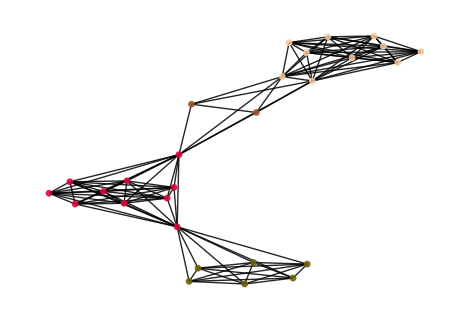

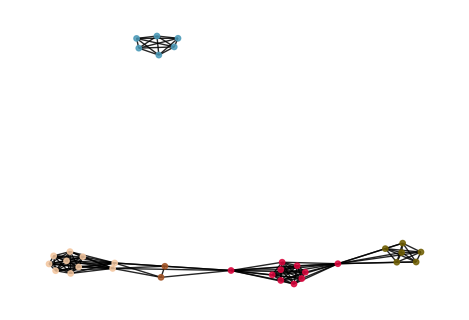

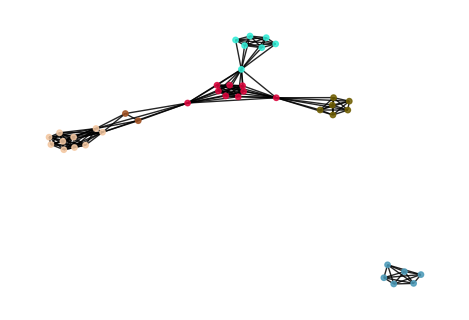

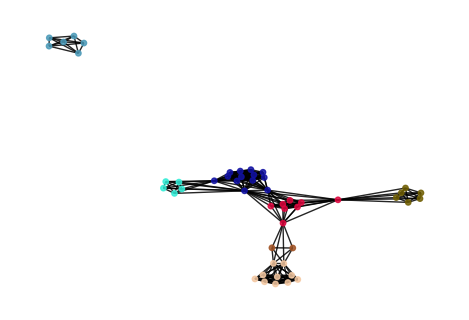

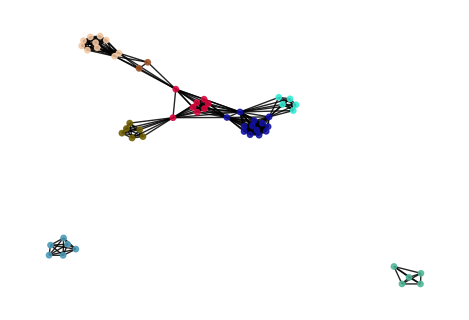

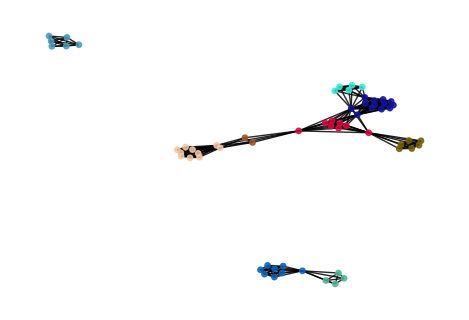

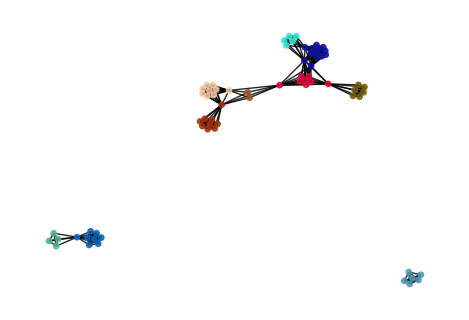

In [184]:
# random pick keys 
keys = random.sample(list(g_data.data_dict.keys()), 10)

# test the class
mg = MetadataGraph()

for k in keys:
    # print("add {}".format(k))
    mg.update_one(g_data.data_dict[k])
    plt.figure(figsize=(4.5, 3))
    mg.draw()
    # plt.tight_layout()
    plt.show()

In [95]:
pprint(mg.G.edges())

EdgeView([('author:RaymondH.Y.Louie', 'category:cs.IT'), ('author:RaymondH.Y.Louie', 'author:YonghuiLi'), ('author:RaymondH.Y.Louie', 'year:2016'), ('author:RaymondH.Y.Louie', 'author:andBrankaVucetic'), ('author:RaymondH.Y.Louie', 'journal:IEEE Transactions on Vehicular Technology, 2010'), ('author:RaymondH.Y.Louie', 'category:math.IT'), ('category:cs.IT', 'author:YonghuiLi'), ('category:cs.IT', 'year:2016'), ('category:cs.IT', 'author:andBrankaVucetic'), ('category:cs.IT', 'journal:IEEE Transactions on Vehicular Technology, 2010'), ('category:cs.IT', 'category:math.IT'), ('author:YonghuiLi', 'year:2016'), ('author:YonghuiLi', 'author:andBrankaVucetic'), ('author:YonghuiLi', 'journal:IEEE Transactions on Vehicular Technology, 2010'), ('author:YonghuiLi', 'category:math.IT'), ('year:2016', 'author:andBrankaVucetic'), ('year:2016', 'journal:IEEE Transactions on Vehicular Technology, 2010'), ('year:2016', 'category:math.IT'), ('author:andBrankaVucetic', 'journal:IEEE Transactions on Vehi

In [185]:
# g_data.data_dict['id_2308.02657']

In [104]:
# mg.G.nodes['category:cs.IT']

{'color': 'red'}